In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_enrich_data(filepath):
    """
    Loads raw data and calculates advanced financial metrics.
    """
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None

    print("Loading and enriching dataset...")
    df = pd.read_csv(filepath)

    # A. Currency Conversion
    df['price_inr'] = df['price_usd'] * 87.0
    
    # B. Sentiment Encoding
    df['is_positive'] = df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)
    
    # C. Date Parsing
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['month_year'] = df['review_date'].dt.to_period('M')

    # D. Income Tier
    def get_income_tier(c):
        if c in ['USA', 'UK', 'Canada', 'Australia', 'Germany', 'UAE']: return 'High Income'
        if c in ['Brazil']: return 'Upper-Middle Income'
        return 'Lower-Middle Income'
    df['income_tier'] = df['country'].apply(get_income_tier)

    # E. Profit Margin Model
    def get_margin(row):
        base_margin = 0.10
        if row['brand'] in ['Xiaomi', 'Realme', 'OnePlus', 'Motorola', 'Vivo']:
            base_margin = 0.15
        if row['income_tier'] != 'High Income':
            base_margin += 0.02
        return base_margin
    df['margin_pct'] = df.apply(get_margin, axis=1)

    # F. Return Rate Model
    quality_score = (0.7 * df['rating']) + (0.3 * df['is_positive'] * 5)
    df['return_rate'] = 0.02 + (0.18 * np.exp(-0.8 * (quality_score - 1)))
    
    # G. Net Profit
    df['gross_profit'] = df['price_inr'] * df['margin_pct']
    df['net_profit_unit'] = df['gross_profit'] - (df['price_inr'] * df['return_rate'] * 0.4)

    return df

In [3]:
def prepare_market_stats(df):
    """
    Aggregates data to 'Country + Model' level for modeling.
    """
    print("Aggregating data to Market-Level...")
    
    market_stats = df.groupby(['country', 'model']).agg({
        'brand': 'first',
        'income_tier': 'first',
        'price_inr': 'mean',
        'age': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean',
        'net_profit_unit': 'mean',
        'return_rate': 'mean',
        'is_positive': 'mean',
        'review_id': 'count'
    }).reset_index()

    market_stats.rename(columns={'is_positive': 'sentiment', 'review_id': 'volume'}, inplace=True)

    # Define Target: 'is_winner' (Top 40% Sentiment AND Top 50% Volume in Country)
    market_stats['is_winner'] = 0
    for c in market_stats['country'].unique():
        country_data = market_stats[market_stats['country'] == c]
        s_thresh = country_data['sentiment'].quantile(0.60)
        v_thresh = country_data['volume'].quantile(0.50)
        
        mask = (market_stats['country'] == c) & \
               (market_stats['sentiment'] > s_thresh) & \
               (market_stats['volume'] > v_thresh)
        market_stats.loc[mask, 'is_winner'] = 1

    # Encoders
    le_brand = LabelEncoder()
    le_country = LabelEncoder()
    le_inc = LabelEncoder()
    
    market_stats['brand_enc'] = le_brand.fit_transform(market_stats['brand'])
    market_stats['country_enc'] = le_country.fit_transform(market_stats['country'])
    market_stats['inc_enc'] = le_inc.fit_transform(market_stats['income_tier'])
    
    return market_stats, (le_brand, le_country, le_inc)

Loading and enriching dataset...
Aggregating data to Market-Level...


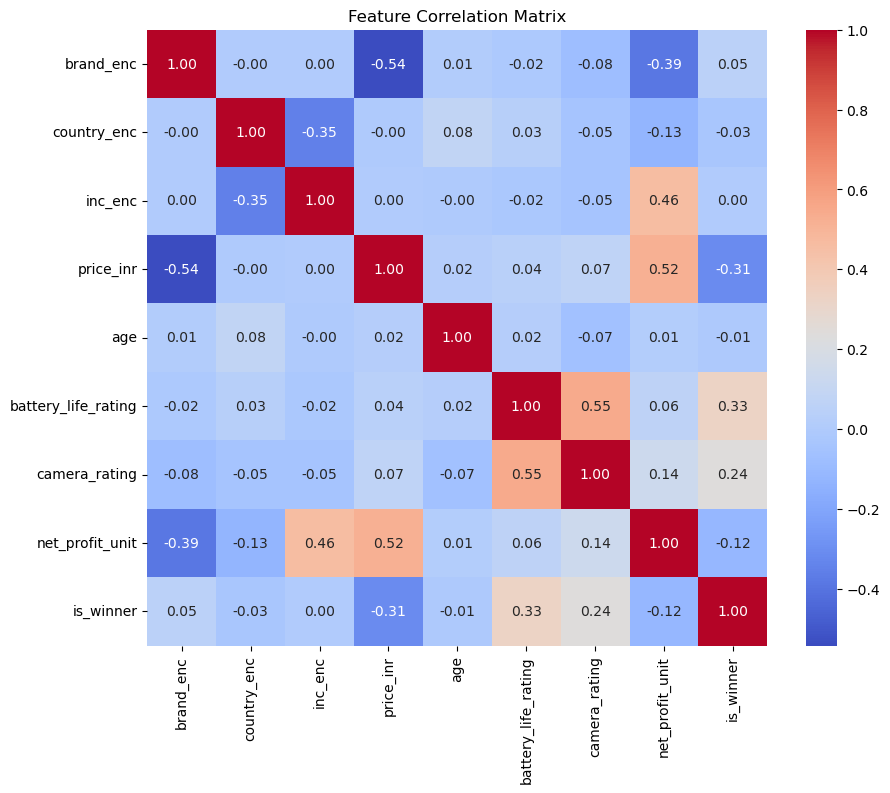

In [4]:
def show_correlation_matrix(market_stats):
    features = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
                'battery_life_rating', 'camera_rating', 'net_profit_unit', 'is_winner']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(market_stats[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

# Run the Load and Prep to display this
filepath = "Mobile Reviews Sentiment.csv"
if os.path.exists(filepath):
    raw_df = load_and_enrich_data(filepath)
    market_stats, encoders = prepare_market_stats(raw_df)
    show_correlation_matrix(market_stats)

Running Model Comparison...

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        42
           1       0.00      0.00      0.00        11

    accuracy                           0.79        53
   macro avg       0.40      0.50      0.44        53
weighted avg       0.63      0.79      0.70        53


--- Random Forest Report ---
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        42
           1       0.44      0.36      0.40        11

    accuracy                           0.77        53
   macro avg       0.64      0.62      0.63        53
weighted avg       0.76      0.77      0.76        53



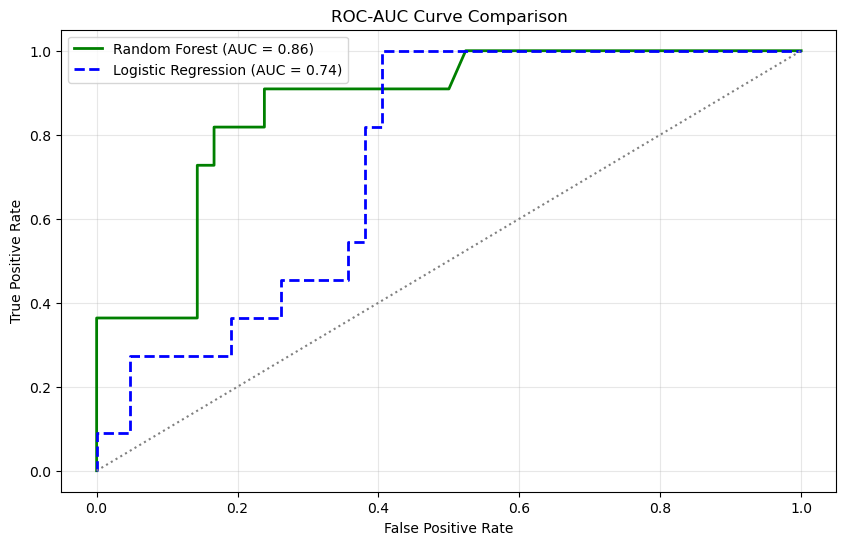

In [5]:
def compare_models(market_stats):
    """
    Compares Logistic Regression and Random Forest.
    Plots ROC AUC Curve.
    """
    print("Running Model Comparison...")
    features = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
                'battery_life_rating', 'camera_rating', 'net_profit_unit']
    X = market_stats[features]
    y = market_stats['is_winner']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 1. Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_prob_lr = lr.predict_proba(X_test)[:, 1]
    y_pred_lr = lr.predict(X_test)

    # 2. Random Forest
    rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    y_prob_rf = rf.predict_proba(X_test)[:, 1]
    y_pred_rf = rf.predict(X_test)

    # Metrics
    print("\n--- Logistic Regression Report ---")
    print(classification_report(y_test, y_pred_lr))
    
    print("\n--- Random Forest Report ---")
    print(classification_report(y_test, y_pred_rf))

    # ROC Plot
    auc_lr = roc_auc_score(y_test, y_prob_lr)
    auc_rf = roc_auc_score(y_test, y_prob_rf)
    
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
    plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, linestyle='--', label=f'Logistic Regression (AUC = {auc_lr:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Execute Comparison
compare_models(market_stats)


🔄 CROSS VALIDATION ANALYSIS (5-Fold)
Running 5 iterations...

✅ Mean Accuracy: 85.27% (Deviation: +/- 11.9%)
✅ Mean ROC AUC:  0.9011 (Deviation: +/- 0.1978)


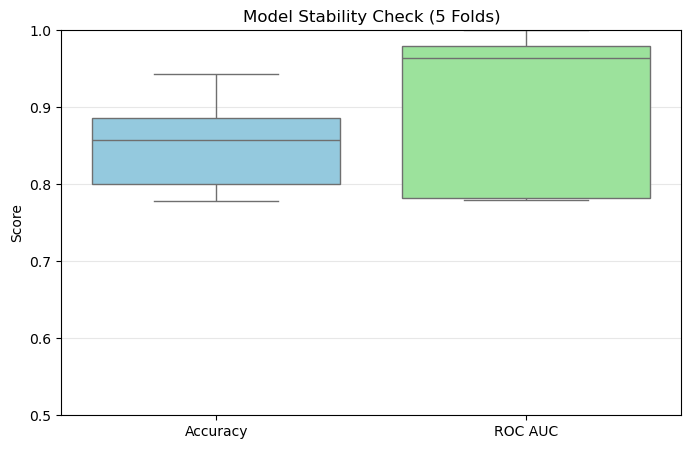

In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def perform_cross_validation(market_stats):
    """
    Performs 5-Fold Stratified Cross Validation on the Random Forest model.
    Checks if the model is stable or overfitting.
    """
    print("\n" + "="*40)
    print("🔄 CROSS VALIDATION ANALYSIS (5-Fold)")
    print("="*40)

    features = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
                'battery_life_rating', 'camera_rating', 'net_profit_unit']
    X = market_stats[features]
    y = market_stats['is_winner']

    # Initialize Model (Same params as final model)
    rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    
    # Define 5-Fold Stratified CV (Preserves % of winners in each fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate Scores
    print("Running 5 iterations...")
    acc_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
    auc_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

    # Report Results
    print(f"\n✅ Mean Accuracy: {acc_scores.mean():.2%} (Deviation: +/- {acc_scores.std()*2:.1%})")
    print(f"✅ Mean ROC AUC:  {auc_scores.mean():.4f} (Deviation: +/- {auc_scores.std()*2:.4f})")
    
    # Visualizing Stability
    results_df = pd.DataFrame({
        'Accuracy': acc_scores,
        'ROC AUC': auc_scores
    })
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=results_df, palette=['skyblue', 'lightgreen'])
    plt.title("Model Stability Check (5 Folds)")
    plt.ylabel("Score")
    plt.ylim(0.5, 1.0) # Scale from 50% to 100%
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

# Execute CV
perform_cross_validation(market_stats)

In [6]:
def train_final_system(market_stats, raw_df):
    print("Training Final System...")
    
    # 1. Train RF on Full Data
    features = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
                'battery_life_rating', 'camera_rating', 'net_profit_unit']
    
    rf_final = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    rf_final.fit(market_stats[features], market_stats['is_winner'])

    # 2. Build Global Hardware KNN
    global_specs = raw_df.groupby('model').agg({
        'price_inr': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean'
    }).reset_index()
    
    knn_cols = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating']
    scaler = StandardScaler()
    X_global = scaler.fit_transform(global_specs[knn_cols])
    
    knn_global = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn_global.fit(X_global)
    
    return rf_final, scaler, global_specs, knn_global

# Train
rf, scaler, global_specs, knn_global = train_final_system(market_stats, raw_df)

Training Final System...


In [7]:
def train_final_system(market_stats, raw_df):
    print("Training Final System...")
    
    # 1. Train RF on Full Data
    features = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
                'battery_life_rating', 'camera_rating', 'net_profit_unit']
    
    rf_final = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    rf_final.fit(market_stats[features], market_stats['is_winner'])

    # 2. Build Global Hardware KNN
    global_specs = raw_df.groupby('model').agg({
        'price_inr': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean'
    }).reset_index()
    
    knn_cols = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating']
    scaler = StandardScaler()
    X_global = scaler.fit_transform(global_specs[knn_cols])
    
    knn_global = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn_global.fit(X_global)
    
    return rf_final, scaler, global_specs, knn_global

# Train
rf, scaler, global_specs, knn_global = train_final_system(market_stats, raw_df)

Training Final System...


In [8]:
def get_forecast(model_name, raw_df):
    sales = raw_df[raw_df['model'] == model_name].groupby('month_year').size()
    
    if len(sales) < 12:
        return sales.mean(), sales
        
    try:
        model = ExponentialSmoothing(sales.values.astype(float), 
                                     trend='add', seasonal=None, damped_trend=True)
        fit = model.fit()
        forecast_val = fit.forecast(1)[0]
        return max(0, forecast_val), sales
    except:
        return sales.mean(), sales

In [9]:
def generate_stocking_plan(target_age, target_country, budget, total_units, 
                           rf_model, scaler, market_stats, encoders, raw_df, global_specs, knn_global, banned_models=[]):
    
    # 1. Filter
    candidates = market_stats[
        (market_stats['country'] == target_country) & 
        (market_stats['price_inr'] <= budget)
    ].copy()

    if candidates.empty: return None

    # 2. AI Scoring
    rf_cols = ['brand_enc', 'country_enc', 'inc_enc', 'price_inr', 'age', 
               'battery_life_rating', 'camera_rating', 'net_profit_unit']
    
    candidates['age'] = target_age 
    candidates['ai_prob'] = rf_model.predict_proba(candidates[rf_cols])[:, 1]
    
    # 3. Harmonic Score Calculation
    # Harmonic Mean = 2 * (P1 * P2) / (P1 + P2)
    # We combine 'AI Probability' and 'Normalized Profit'
    max_p = candidates['net_profit_unit'].max()
    candidates['norm_profit'] = candidates['net_profit_unit'] / max_p
    
    # Add small epsilon to avoid division by zero
    eps = 1e-9
    candidates['final_score'] = 2 * (candidates['ai_prob'] * candidates['norm_profit']) / \
                                (candidates['ai_prob'] + candidates['norm_profit'] + eps)

    candidates = candidates.sort_values(by='final_score', ascending=False)

    # 4. Selection & Substitution
    final_list = []
    knn_cols = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating']

    for idx, row in candidates.iterrows():
        if len(final_list) >= 5: break
        m_name = row['model']
        
        if m_name in banned_models:
            print(f"Model '{m_name}' unavailable. Searching Global Specs...")
            target_spec_row = global_specs[global_specs['model'] == m_name]
            target_vec = scaler.transform(target_spec_row[knn_cols].values) if not target_spec_row.empty \
                         else scaler.transform([row[knn_cols].values])

            dists, indices = knn_global.kneighbors(target_vec)
            found = False
            for i in indices[0]:
                alt_name = global_specs.iloc[i]['model']
                is_available_locally = not market_stats[
                    (market_stats['country'] == target_country) & (market_stats['model'] == alt_name)
                ].empty
                
                if (alt_name not in banned_models) and \
                   (alt_name not in [x['model'] for x in final_list]) and \
                   is_available_locally:
                    
                    local_data = market_stats[
                        (market_stats['country'] == target_country) & (market_stats['model'] == alt_name)
                    ].iloc[0]
                    
                    print(f"   Swapped with: {alt_name}")
                    new_entry = row.copy()
                    new_entry['model'] = alt_name
                    new_entry['price_inr'] = local_data['price_inr']
                    new_entry['net_profit_unit'] = local_data['net_profit_unit']
                    new_entry['is_substitute'] = True
                    final_list.append(new_entry)
                    found = True
                    break
            if not found: print(f"   No substitute found for {m_name}.")
        else:
            row['is_substitute'] = False
            final_list.append(row)

    # 5. Finalize
    res = pd.DataFrame(final_list)
    res['forecast'] = res['model'].apply(lambda x: get_forecast(x, raw_df)[0])
    
    total_f = res['forecast'].sum()
    if total_f == 0: total_f = 1
    
    # Calculate % Sales
    res['pct_sales'] = res['forecast'] / total_f
    res['suggested_qty'] = (res['pct_sales'] * total_units).astype(int)
    res['total_profit'] = res['suggested_qty'] * res['net_profit_unit']
    
    return res


 AI INVENTORY MANAGER
Available Countries: Australia, Brazil, Canada, Germany, India, UAE, UK, USA


Target Country (Default: India):  UK
Target Age:  34
Budget (INR):  90000
Total Units:  1000



STOCKING PLAN FOR UK
| Model          | Pred. Prob.   | % Sales   | Harmonic Score   | Qty   | Total Profit   |
|:---------------|:--------------|:----------|:-----------------|:------|:---------------|
| OnePlus Nord 3 | 0.69          | 18.8%     | 0.814            | 187   | ₹12,75,783     |
| Realme 12 Pro  | 0.66          | 26.0%     | 0.614            | 260   | ₹10,19,382     |
| Pixel 6        | 0.49          | 18.4%     | 0.568            | 183   | ₹8,40,569      |
| Pixel 8        | 0.49          | 18.4%     | 0.56             | 183   | ₹8,12,361      |
| Moto G Power   | 0.41          | 18.4%     | 0.527            | 184   | ₹9,46,283      |



Remove Model (or Enter to Finish):  


Finalizing...


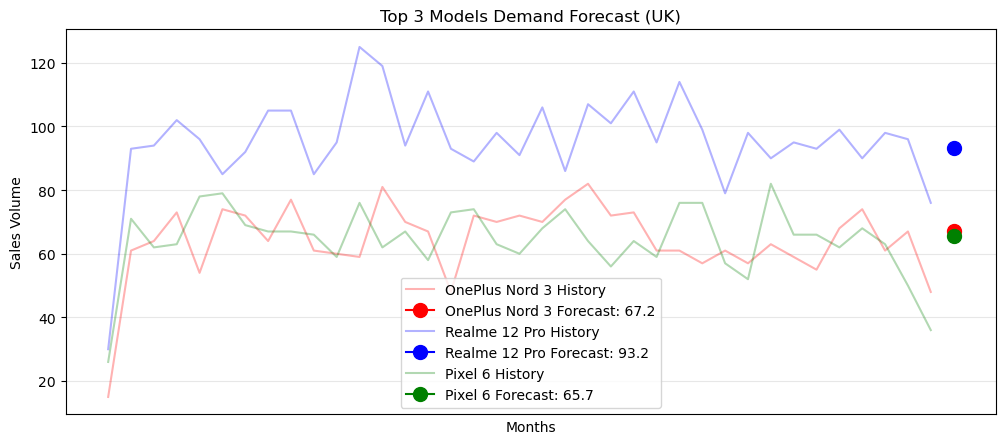

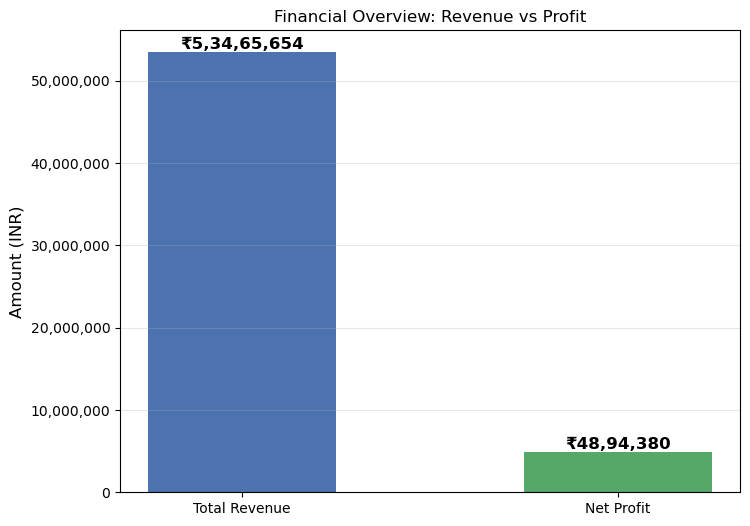

In [13]:
# === FINAL EXECUTION BLOCK ===
import matplotlib.ticker as ticker

# Helper: Indian Number Formatting (XX,XX,XXX)
def format_indian(n):
    n = int(n)
    s = str(n)
    if len(s) <= 3: return f"₹{s}"
    
    # Split last 3 digits
    last_three = s[-3:]
    remaining = s[:-3]
    
    # Group remaining by 2
    groups = []
    while remaining:
        groups.append(remaining[-2:])
        remaining = remaining[:-2]
    
    groups.reverse()
    formatted = ",".join(groups) + "," + last_three
    return f"₹{formatted}"

print("\n" + "="*50)
print(" AI INVENTORY MANAGER")
print("="*50)

# 1. Inputs with Country List
available_countries = sorted(market_stats['country'].unique())
print(f"Available Countries: {', '.join(available_countries)}")

u_country = input("Target Country (Default: India): ").strip() or "India"

# Validation
if u_country not in available_countries: 
    print(f"Country '{u_country}' not found in list. Defaulting to 'India'.")
    u_country = "India"

try:
    u_age = int(input("Target Age: "))
    u_budget = float(input("Budget (INR): "))
    u_units = int(input("Total Units: "))
except ValueError:
    print("Invalid numbers entered. Using defaults.")
    u_age, u_budget, u_units = 25, 40000, 500

banned = []

# 2. Generation Loop
while True:
    plan = generate_stocking_plan(u_age, u_country, u_budget, u_units, 
                                  rf, scaler, market_stats, encoders, raw_df, global_specs, knn_global, banned)
    
    if plan is None: print("No matching phones."); break

    # 3. Display Table
    print(f"\nSTOCKING PLAN FOR {u_country.upper()}")
    
    view = plan[['model', 'ai_prob', 'pct_sales', 'final_score', 'suggested_qty', 'total_profit']].copy()
    
    # Apply Formatting
    view['ai_prob'] = view['ai_prob'].apply(lambda x: f"{x:.2f}")
    view['pct_sales'] = view['pct_sales'].apply(lambda x: f"{x:.1%}")
    view['final_score'] = view['final_score'].apply(lambda x: f"{x:.3f}")
    
    # Use Indian Format for Profit
    view['total_profit'] = view['total_profit'].apply(format_indian)
    
    view.columns = ['Model', 'Pred. Prob.', '% Sales', 'Harmonic Score', 'Qty', 'Total Profit']
    
    try:
        print(view.to_markdown(index=False, numalign="left", stralign="left"))
    except:
        print(view.to_string(index=False))

    # 4. Modification
    cmd = input("\nRemove Model (or Enter to Finish): ").strip()
    if cmd == "":
        print("Finalizing...")
        
        # --- GRAPH 1: TOP 3 MODELS FORECAST ---
        top_3 = plan.head(3)
        colors = ['red', 'blue', 'green']
        
        plt.figure(figsize=(12, 5))
        
        for i, (idx, row) in enumerate(top_3.iterrows()):
            model_name = row['model']
            pred, hist = get_forecast(model_name, raw_df)
            color = colors[i % len(colors)]
            
            plt.plot(hist.index.astype(str), hist.values, color=color, alpha=0.3, label=f'{model_name} History')
            next_step = len(hist)
            plt.plot(next_step, pred, marker='o', color=color, markersize=10, 
                     label=f'{model_name} Forecast: {pred:.1f}')

        plt.title(f"Top 3 Models Demand Forecast ({u_country})")
        plt.xlabel("Months")
        plt.ylabel("Sales Volume")
        plt.xticks([]) 
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # --- GRAPH 2: FINANCIAL SUMMARY (Single Scale) ---
        total_revenue = (plan['price_inr'] * plan['suggested_qty']).sum()
        total_profit_val = plan['total_profit'].sum()

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot Bars on SAME axis
        bars = ax.bar(['Total Revenue', 'Net Profit'], 
                      [total_revenue, total_profit_val], 
                      color=['#4c72b0', '#55a868'], 
                      width=0.5)

        # Add Values on Top of Bars (Indian Format)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    format_indian(height),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

        ax.set_ylabel('Amount (INR)', fontsize=12)
        
        # Format Y-Axis to avoid scientific notation
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        plt.title("Financial Overview: Revenue vs Profit")
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        
        break
    else:
        match = [m for m in plan['model'] if m.lower() == cmd.lower()]
        if match: banned.append(match[0])
        else: print("Model not found.")